In [207]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.feature import RegexTokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import avg,count
from underthesea import word_tokenize

In [193]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [198]:
df = spark.read.csv('data.csv', inferSchema=True, header=True)
df.show(5)

+------+--------------------+
|status|             content|
+------+--------------------+
|     2|K có ảnh nên dùng...|
|     2|Sản phẩm rất xinh...|
|     0|Nhận hàng đúng mô...|
|     2|Mua hộ nên ko có ...|
|     2|Tai nghe nghe ổn,...|
+------+--------------------+
only showing top 5 rows



In [199]:
df_pd = df.toPandas()['status'].value_counts()

D:\Soft\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='status', ylabel='count'>

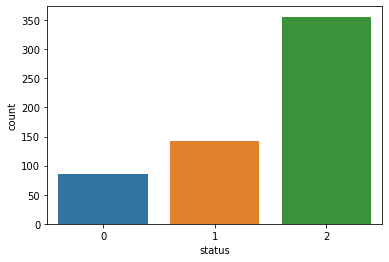

In [200]:
sns.countplot(df.toPandas()['status'])

# Preprocess data

In [188]:
# Tokenizer
def tokenizer(row):
    return word_tokenize(row, format='text')


In [189]:
stopwords = []
with open("vietnamese-stopwords-dash.txt", encoding='utf-8') as f:
    for line in f:
        stopwords.append(line.split('\n')[0])

In [190]:
def remove_stop_words(corpus):
    results = corpus.split(' ')
    for stopword in stopwords:
        if stopword in results:
            results.remove(stopword)    
    return results

In [202]:
def preprocess_data(data):
        
        char_replace_regex = r"[\,,\.,\;,\“,\”,\",\',\:,\!,\?,\-,\@,\#,\$,\%,\^,\&,\*]"
        data = (data.withColumn("content", f.regexp_replace(f.col("content"), char_replace_regex, ""))
                .withColumn('content', f.regexp_replace(f.col('content'), "[0-9]", " "))
                .withColumn('content', f.regexp_replace(f.col('content'), " +", " "))
                .withColumn('content', f.lower(f.col('content')))
                .withColumn('content', f.trim(f.col('content')))
                .filter("content != ''")
        )  
        df_pd = data.toPandas()
        df_pd['token'] = df_pd['content'].apply(tokenizer)
        df_pd['token'] = df_pd['token'].apply(remove_stop_words)
        df = spark.createDataFrame(df_pd)

        return df


In [208]:
df_clean = preprocess_data(df)

In [209]:
df_clean.show(5)

+------+--------------------+--------------------+
|status|             content|               token|
+------+--------------------+--------------------+
|     2|k có ảnh nên dùng...|[k, ảnh, tạm, ảnh...|
|     2|sản phẩm rất xinh...|[sản_phẩm, xinh_đ...|
|     0|nhận hàng đúng mô...|[hàng, mô_tả, tai...|
|     2|mua hộ nên ko có ...|[mua, hộ, ko, ảnh...|
|     2|tai nghe nghe ổn ...|[tai, nghe, ổn, g...|
+------+--------------------+--------------------+
only showing top 5 rows



# Train model

In [210]:
hashing_tf = HashingTF(inputCol='token', outputCol='term_frequency')

idf = IDF(inputCol='term_frequency', outputCol='features',minDocFreq=5)

lr = LogisticRegression(labelCol='status')

In [261]:
(train_data, test_data) = df_clean.randomSplit([0.99,0.01], seed=13)

In [262]:
pipeline = Pipeline(stages=[hashing_tf, idf, lr])
model_lr = pipeline.fit(train_data)

In [263]:
trained_df = model_lr.transform(train_data)
test_df = model_lr.transform(test_data)

# Evaluate model

In [264]:
evaluator = MulticlassClassificationEvaluator(labelCol='status', metricName='accuracy')
acc_train = evaluator.evaluate(trained_df)
acc_test = evaluator.evaluate(test_df)

print('Accuracy training data: ', acc_train)
print('Accuracy testing data: ', acc_test)



Accuracy training data:  0.9896551724137931
Accuracy testing data:  0.75


In [120]:
# model_lr.save("E:\\1OneDrive\\OneDrive - Trường ĐH CNTT - University of Information Technology\\2021_1\\Big Data\\project\\model_lr.pkl")

# Test model with product

In [269]:
import crawl

url = 'https://shopee.vn/Robot-h%C3%BAt-b%E1%BB%A5i-Bowai-th%C3%B4ng-minh-Robot-lau-nh%C3%A0-t%E1%BB%B1-%C4%91%E1%BB%99ng-c%C3%B4ng-ngh%E1%BB%87-AI-3-trong-1-i.236159821.8842672143?sp_atk=06f423da-addb-49d8-8895-bd0ef651bcd9'

list_cmt = crawl.load_url_selenium_shopee(url)
dict = {'content':list_cmt}
df_pd = pd.DataFrame(dict)
test_df = spark.createDataFrame(df_pd)




====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST chromedriver version for 96.0.4664 google-chrome
Driver [C:\Users\giaba\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache


Loading url= https://shopee.vn/Robot-h%C3%BAt-b%E1%BB%A5i-Bowai-th%C3%B4ng-minh-Robot-lau-nh%C3%A0-t%E1%BB%B1-%C4%91%E1%BB%99ng-c%C3%B4ng-ngh%E1%BB%87-AI-3-trong-1-i.236159821.8842672143?sp_atk=06f423da-addb-49d8-8895-bd0ef651bcd9


D:\Soft\anaconda\lib\site-packages\selenium\webdriver\remote\webelement.py:484: UserWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  warnings.warn("find_element_by_* commands are deprecated. Please use find_element() instead")


next page
next page
next page
next page
next page


In [366]:
test_df = preprocess_data(test_df)
predict = model_lr.transform(test_df).select('content','prediction')

In [379]:
result_pd_textlabel = predict.toPandas()

result_pd_textlabel['prediction'] = result_pd_textlabel['prediction'].replace([0,1,2], ['Tệ', 'Ổn', 'Tốt'])

In [380]:
def analyze(result_pd):
    eva_product = result_pd['prediction'].value_counts()
    total = result_pd['prediction'].count()
    # predict_num = result_pd['prediction'].mean()
    
    list_eva = [eva_product['Tệ'], eva_product['Ổn'], eva_product['Tốt']]
    list_eva_ratio = [num/total for num in list_eva]
    index_chosen = np.argmax(list_eva_ratio)
    # print(list_eva_ratio)
    if (index_chosen==0):
        print('Sản phầm khá tệ! Không nên mua :(')
    elif (index_chosen==1):
        print('Sản phầm ổn! :)')
    else:
        print('Sản phẩm rất tốt! Nên mua <3')




Sản phẩm rất tốt! Nên mua <3


D:\Soft\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


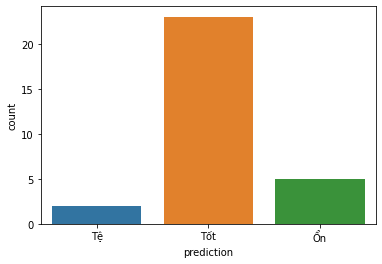

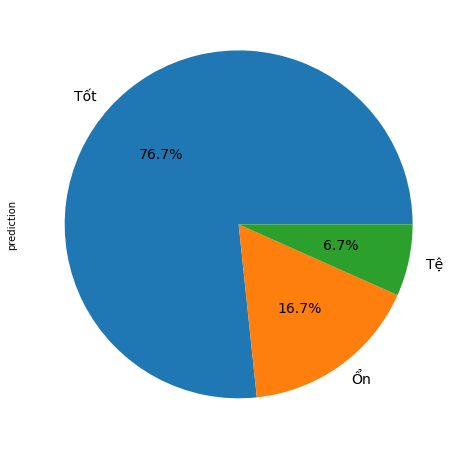

In [382]:
analyze(result_pd_textlabel)
sns.countplot(result_pd_textlabel['prediction'])
plt.figure(figsize=(16,8))
fig = result_pd_textlabel['prediction'].value_counts().plot(kind='pie',autopct='%1.1f%%', fontsize=14)

